# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_086  Q9NZ94;Q9NZ94-2;Q9NZ94-3   13.973
Sample_176  A0A0A0MT69                 18.177
Sample_059  A0A0C4DH24                 16.744
Sample_203  P01593;P01594              19.437
Sample_005  P02768                     28.722
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups             
Sample_025  Q9NY15                        15.315
Sample_059  B1AJR6;B1AJR9;B1AJS0;O14522   15.726
Sample_151  A0A075B6R2                    16.059
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.980
            A0A075B6Q5                 13.833
            A0A075B6R2                 12.883
            A0A075B6S5                 13.788
            A0A087WSY4                 13.759
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.974
            Q9UI40;Q9UI40-2            13.198
            Q9UIW2                     14.224
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.470
            Q9UP79                     11.575
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.099,15.050,16.842,19.863,16.060,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.493,19.067,...,15.528,15.576,13.961,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.061,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.015,17.705,17.039,15.692,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.175,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.763,15.345,17.084,18.708,14.249,19.433,11.685,10.595
Sample_207,15.739,16.877,15.469,16.898,13.683,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.364,12.154,13.021,13.025,13.103,13.443,12.637,13.081,13.051,13.217
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.244,19.067,16.127,...,11.975,13.363,12.832,12.223,12.353,13.583,13.327,13.329,12.509,12.065
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.899,12.383,12.095,13.006,12.462,12.611,11.690,13.088,12.643,13.426
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.644,11.850,13.969,12.573,11.624,14.837,11.774,13.194,10.663,12.957
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.027,14.119,11.931,12.905,12.706,12.766,13.558,12.912,12.107,13.801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.885,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 346.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.31it/s]

100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.62it/s]

100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

100%|██████████| 3/3 [00:00<00:00,  5.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.47it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.70it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.40it/s]

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

100%|██████████| 5/5 [00:01<00:00,  4.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.40it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.33it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.49it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.33it/s]

100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.79it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.25it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.61it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.28it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.23it/s]

100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.49it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.81it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.45it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.09it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.03it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.92it/s]

100%|██████████| 8/8 [00:01<00:00,  3.91it/s]

100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.73it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.91it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.25it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.85it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.79it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.88it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.85it/s]

100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.84it/s]

 30%|███       | 3/10 [00:00<00:01,  5.05it/s]

 40%|████      | 4/10 [00:00<00:01,  4.79it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.45it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.26it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.10it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.99it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.95it/s]

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.30it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.22it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.89it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.33it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.49it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.25it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.20it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.15it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.96it/s]

100%|██████████| 11/11 [00:02<00:00,  3.95it/s]

100%|██████████| 11/11 [00:02<00:00,  4.54it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.14it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.27it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.84it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.97it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.07it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.95it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.83it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.04it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.98it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.87it/s]

100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.74it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.33it/s]

 31%|███       | 4/13 [00:00<00:02,  3.53it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.19it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.11it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.78it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.77it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.72it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.72it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.65it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.68it/s]

100%|██████████| 13/13 [00:04<00:00,  2.61it/s]

100%|██████████| 13/13 [00:04<00:00,  2.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.28it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.99it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.81it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.77it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.74it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.63it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.67it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.57it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.56it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.55it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.59it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.14it/s]

100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

100%|██████████| 14/14 [00:04<00:00,  3.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.01it/s]

 20%|██        | 3/15 [00:00<00:03,  3.37it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.15it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.98it/s]

 40%|████      | 6/15 [00:01<00:02,  3.02it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.13it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.08it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.27it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.49it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.63it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.64it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.59it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.61it/s]

100%|██████████| 15/15 [00:04<00:00,  3.73it/s]

100%|██████████| 15/15 [00:04<00:00,  3.44it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.033 0.004          0.785 0.323       0.125   
2             0.003 0.000      0.035 0.001          0.672 0.097       0.570   
3             0.003 0.000      0.035 0.001          0.665 0.111       0.567   
4             0.003 0.000      0.034 0.003          0.676 0.109       0.578   
5             0.003 0.000      0.035 0.003          0.780 0.091       0.800   
6             0.003 0.000      0.035 0.000          0.773 0.091       0.797   
7             0.003 0.000      0.035 0.002          0.780 0.085       0.806   
8             0.003 0.000      0.035 0.002          0.787 0.085       0.806   
9             0.003 0.000      0.035 0.000          0.786 0.086       0.804   
10            0.003 0.000      0.035 0.008          0.793 0.087       0.808   
11            0.003 0.000      0.032 0.004          0.790 0.083       0.806   
12            0.003 0.000      0.033 0.003          0.789 0.082       0.822   
13            0.004 0.003      0.041 0.012          0.790 0.078       0.782   
14            0.004 0.003      0.044 0.017          0.790 0.078       0.783   
15            0.005 0.004      0.046 0.014          0.807 0.078       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.207 0.133                  0.554 0.044        0.856   
2          0.125   0.610 0.094                  0.682 0.067        0.749   
3          0.116   0.606 0.097                  0.677 0.071        0.741   
4          0.123   0.616 0.098                  0.685 0.070        0.741   
5          0.113   0.785 0.081                  0.816 0.069        0.896   
6          0.113   0.780 0.081                  0.811 0.071        0.894   
7          0.110   0.788 0.077                  0.819 0.066        0.893   
8          0.111   0.792 0.075                  0.822 0.064        0.894   
9          0.102   0.790 0.073                  0.820 0.062        0.892   
10         0.115   0.797 0.084                  0.826 0.072        0.908   
11         0.115   0.794 0.080                  0.824 0.069        0.906   
12         0.101   0.801 0.074                  0.829 0.065        0.906   
13         0.109   0.781 0.074                  0.814 0.062        0.908   
14         0.109   0.782 0.075                  0.814 0.063        0.906   
15         0.099   0.799 0.069                  0.829 0.059        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.821 0.085        210.000 0.000  
2          0.071                  0.700 0.087        210.000 0.000  
3          0.073                  0.692 0.091        210.000 0.000  
4          0.069                  0.695 0.084        210.000 0.000  
5          0.051                  0.876 0.056        210.000 0.000  
6          0.050                  0.871 0.056        210.000 0.000  
7          0.051                  0.867 0.057        210.000 0.000  
8          0.049                  0.868 0.056        210.000 0.000  
9          0.051                  0.869 0.057        210.000 0.000  
10         0.050                  0.888 0.058        210.000 0.000  
11         0.051                  0.885 0.061        210.000 0.000  
12         0.052                  0.885 0.060        210.000 0.000  
13         0.050                  0.889 0.061        210.000 0.000  
14         0.051                  0.887 0.061        210.000 0.000  
15         0.049                  0.894 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 535.06it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.11it/s]

100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.89it/s]

100%|██████████| 4/4 [00:01<00:00,  3.33it/s]

100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.41it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.17it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.08it/s]

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]

100%|██████████| 5/5 [00:01<00:00,  3.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.04it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.55it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.88it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.10it/s]

100%|██████████| 6/6 [00:01<00:00,  2.66it/s]

100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.79it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.52it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.19it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.96it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.75it/s]

100%|██████████| 7/7 [00:01<00:00,  3.35it/s]

100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.72it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.86it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.95it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.62it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.48it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.39it/s]

100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

100%|██████████| 8/8 [00:02<00:00,  3.73it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.53it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.76it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.62it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.66it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.64it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.42it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.40it/s]

100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.49it/s]

 30%|███       | 3/10 [00:00<00:01,  3.83it/s]

 40%|████      | 4/10 [00:01<00:01,  3.62it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.25it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.25it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.14it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.08it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.15it/s]

100%|██████████| 10/10 [00:03<00:00,  3.09it/s]

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.89it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.18it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.01it/s]

 45%|████▌     | 5/11 [00:01<00:02,  3.00it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.82it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.96it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.03it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.17it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.16it/s]

100%|██████████| 11/11 [00:03<00:00,  3.23it/s]

100%|██████████| 11/11 [00:03<00:00,  3.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.86it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.37it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.10it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.97it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.91it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.87it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.96it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.02it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.11it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.15it/s]

100%|██████████| 12/12 [00:03<00:00,  3.17it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.27it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.52it/s]

 31%|███       | 4/13 [00:00<00:02,  4.03it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.63it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.25it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.85it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.53it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.39it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.26it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.36it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.53it/s]

100%|██████████| 13/13 [00:04<00:00,  2.78it/s]

100%|██████████| 13/13 [00:04<00:00,  2.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.04it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.72it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.15it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.71it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.48it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.43it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.46it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.35it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.37it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.24it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.83it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.73it/s]

100%|██████████| 14/14 [00:04<00:00,  2.67it/s]

100%|██████████| 14/14 [00:04<00:00,  3.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.98it/s]

 20%|██        | 3/15 [00:00<00:03,  3.02it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.83it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.49it/s]

 40%|████      | 6/15 [00:02<00:03,  2.36it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.70it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.70it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.70it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.84it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.96it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.03it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.10it/s]

100%|██████████| 15/15 [00:05<00:00,  3.01it/s]

100%|██████████| 15/15 [00:05<00:00,  2.86it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.046 0.017          0.087 0.248       0.009   
2             0.003 0.002      0.037 0.007          0.639 0.099       0.499   
3             0.003 0.000      0.036 0.005          0.717 0.097       0.626   
4             0.003 0.002      0.037 0.008          0.791 0.089       0.605   
5             0.004 0.003      0.042 0.015          0.790 0.076       0.789   
6             0.005 0.006      0.047 0.019          0.801 0.082       0.791   
7             0.005 0.004      0.046 0.015          0.801 0.084       0.811   
8             0.004 0.002      0.042 0.013          0.783 0.083       0.810   
9             0.004 0.004      0.048 0.017          0.776 0.083       0.815   
10            0.004 0.003      0.047 0.017          0.785 0.088       0.818   
11            0.005 0.004      0.053 0.018          0.792 0.090       0.802   
12            0.007 0.006      0.051 0.017          0.799 0.089       0.797   
13            0.005 0.003      0.043 0.018          0.788 0.088       0.791   
14            0.005 0.003      0.041 0.012          0.797 0.086       0.789   
15            0.005 0.004      0.053 0.020          0.798 0.087       0.791   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.868   
2          0.106   0.553 0.086                  0.644 0.059        0.723   
3          0.106   0.660 0.075                  0.719 0.054        0.788   
4          0.113   0.678 0.082                  0.742 0.056        0.808   
5          0.110   0.784 0.070                  0.816 0.058        0.902   
6          0.108   0.791 0.073                  0.822 0.060        0.904   
7          0.106   0.801 0.073                  0.830 0.061        0.904   
8          0.108   0.792 0.074                  0.822 0.062        0.901   
9          0.105   0.791 0.075                  0.820 0.064        0.900   
10         0.114   0.796 0.077                  0.826 0.065        0.900   
11         0.122   0.791 0.082                  0.822 0.068        0.910   
12         0.113   0.792 0.077                  0.823 0.065        0.911   
13         0.114   0.784 0.077                  0.816 0.063        0.910   
14         0.109   0.788 0.072                  0.819 0.060        0.910   
15         0.111   0.789 0.074                  0.821 0.062        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.834 0.087        210.000 0.000  
2          0.082                  0.641 0.103        210.000 0.000  
3          0.066                  0.771 0.083        210.000 0.000  
4          0.065                  0.784 0.079        210.000 0.000  
5          0.050                  0.876 0.062        210.000 0.000  
6          0.049                  0.877 0.062        210.000 0.000  
7          0.050                  0.875 0.063        210.000 0.000  
8          0.053                  0.875 0.062        210.000 0.000  
9          0.053                  0.873 0.062        210.000 0.000  
10         0.052                  0.873 0.061        210.000 0.000  
11         0.050                  0.889 0.058        210.000 0.000  
12         0.050                  0.893 0.057        210.000 0.000  
13         0.050                  0.892 0.057        210.000 0.000  
14         0.049                  0.891 0.058        210.000 0.000  
15         0.050                  0.895 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1039.48it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 19.10it/s]

100%|██████████| 3/3 [00:00<00:00, 18.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.38it/s]

100%|██████████| 4/4 [00:00<00:00, 14.76it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.95it/s]

100%|██████████| 5/5 [00:00<00:00, 17.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.54it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.49it/s]

100%|██████████| 6/6 [00:00<00:00, 13.71it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.02it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.22it/s]

100%|██████████| 7/7 [00:00<00:00, 18.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.65it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 17.76it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 15.19it/s]

100%|██████████| 8/8 [00:00<00:00, 15.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.80it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.98it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.82it/s]

100%|██████████| 9/9 [00:00<00:00, 14.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.49it/s]

 50%|█████     | 5/10 [00:00<00:00, 15.31it/s]

 70%|███████   | 7/10 [00:00<00:00, 15.27it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.51it/s]

100%|██████████| 10/10 [00:00<00:00, 14.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.56it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 18.57it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.96it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.84it/s]

100%|██████████| 11/11 [00:00<00:00, 16.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.75it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.35it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.50it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.06it/s]

100%|██████████| 12/12 [00:00<00:00, 15.54it/s]

100%|██████████| 12/12 [00:00<00:00, 15.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.13it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.24it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.76it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.52it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.70it/s]

100%|██████████| 13/13 [00:00<00:00, 15.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.84it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.67it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.41it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.94it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.14it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.16it/s]

100%|██████████| 14/14 [00:01<00:00, 12.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 24.45it/s]

 40%|████      | 6/15 [00:00<00:00, 18.06it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 17.01it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 16.14it/s]

 80%|████████  | 12/15 [00:00<00:00, 16.16it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 15.90it/s]

100%|██████████| 15/15 [00:00<00:00, 16.55it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.036 0.009          0.000 0.000       0.000   
2             0.005 0.004      0.055 0.020          0.643 0.100       0.475   
3             0.003 0.001      0.036 0.008          0.614 0.106       0.480   
4             0.005 0.005      0.055 0.020          0.604 0.098       0.487   
5             0.006 0.006      0.051 0.025          0.620 0.103       0.502   
6             0.006 0.005      0.058 0.026          0.617 0.090       0.506   
7             0.005 0.004      0.058 0.035          0.595 0.108       0.502   
8             0.004 0.003      0.047 0.018          0.576 0.105       0.486   
9             0.004 0.003      0.049 0.019          0.657 0.091       0.618   
10            0.006 0.005      0.060 0.027          0.663 0.091       0.630   
11            0.006 0.006      0.057 0.028          0.655 0.091       0.640   
12            0.005 0.005      0.060 0.025          0.648 0.077       0.639   
13            0.005 0.004      0.051 0.023          0.672 0.098       0.644   
14            0.005 0.005      0.056 0.025          0.707 0.078       0.657   
15            0.007 0.006      0.062 0.030          0.704 0.082       0.646   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.747   
2          0.112   0.540 0.092                  0.641 0.059        0.695   
3          0.113   0.531 0.090                  0.627 0.063        0.697   
4          0.108   0.533 0.086                  0.625 0.059        0.698   
5          0.119   0.546 0.083                  0.635 0.057        0.706   
6          0.115   0.548 0.078                  0.636 0.052        0.700   
7          0.125   0.535 0.095                  0.624 0.061        0.691   
8          0.134   0.517 0.098                  0.611 0.059        0.681   
9          0.119   0.631 0.088                  0.690 0.067        0.781   
10         0.113   0.641 0.086                  0.697 0.067        0.778   
11         0.119   0.643 0.092                  0.697 0.074        0.780   
12         0.118   0.639 0.084                  0.693 0.067        0.778   
13         0.120   0.652 0.087                  0.706 0.069        0.791   
14         0.113   0.675 0.075                  0.728 0.058        0.828   
15         0.108   0.668 0.076                  0.722 0.060        0.824   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.702 0.083        210.000 0.000  
2          0.080                  0.679 0.079        210.000 0.000  
3          0.082                  0.665 0.087        210.000 0.000  
4          0.077                  0.661 0.079        210.000 0.000  
5          0.069                  0.668 0.080        210.000 0.000  
6          0.069                  0.662 0.080        210.000 0.000  
7          0.073                  0.644 0.087        210.000 0.000  
8          0.071                  0.635 0.085        210.000 0.000  
9          0.076                  0.763 0.084        210.000 0.000  
10         0.076                  0.759 0.086        210.000 0.000  
11         0.076                  0.763 0.080        210.000 0.000  
12         0.073                  0.760 0.076        210.000 0.000  
13         0.067                  0.769 0.080        210.000 0.000  
14         0.057                  0.800 0.067        210.000 0.000  
15         0.058                  0.793 0.068 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,12,15
score_time,15,15,15
test_precision,15,7,14
test_recall,12,10,14
test_f1,12,7,14
test_balanced_accuracy,12,7,14
test_roc_auc,15,15,14
test_average_precision,15,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.61it/s]

 20%|██        | 3/15 [00:00<00:03,  3.72it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.27it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.10it/s]

 40%|████      | 6/15 [00:01<00:02,  3.04it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.09it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.06it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.79it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.54it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.45it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.41it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.31it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.23it/s]

100%|██████████| 15/15 [00:05<00:00,  2.05it/s]

100%|██████████| 15/15 [00:05<00:00,  2.59it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 21.06it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.57it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 11.20it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.82it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.87it/s]

100%|██████████| 14/14 [00:01<00:00, 11.18it/s]

100%|██████████| 14/14 [00:01<00:00, 11.52it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.99it/s]

 20%|██        | 3/15 [00:00<00:02,  4.94it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.07it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.50it/s]

 40%|████      | 6/15 [00:01<00:03,  2.94it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.95it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.73it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.71it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.86it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.07it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.97it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.23it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.40it/s]

100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.29it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


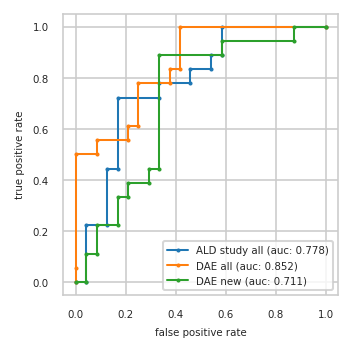

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.222   0.000 0.500   0.042 0.111
3          0.125 0.222   0.083 0.500   0.083 0.111
4          0.125 0.444   0.083 0.556   0.083 0.222
5          0.167 0.444   0.208 0.556   0.167 0.222
6          0.167 0.722   0.208 0.611   0.167 0.333
7          0.333 0.722   0.250 0.611   0.208 0.333
8          0.333 0.778   0.250 0.778   0.208 0.389
9          0.458 0.778   0.375 0.778   0.292 0.389
10         0.458 0.833   0.375 0.833   0.292 0.444
11         0.542 0.833   0.417 0.833   0.333 0.444
12         0.542 0.889   0.417 1.000   0.333 0.889
13         0.583 0.889   1.000 1.000   0.583 0.889
14         0.583 1.000     NaN   NaN   0.583 0.944
15         1.000 1.000     NaN   NaN   0.875 0.944
16           NaN   NaN     NaN   NaN   0.875 1.000
17           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A087X136;P51801,P16519;P16519-3,J3KSJ8;Q9UD71;Q9UD71-2
2,G3XAI2;P07942,G3V4U0;G3XA98;Q9UBX5,P51688
3,P04075,P02766,Q96GD0
4,Q99983,P61981,P31321
5,P61981,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P14174,Q14894,E9PK25;G3V1A4;P23528
7,Q9Y2T3;Q9Y2T3-3,P14174,P31150
8,P00338;P00338-3,P04075,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


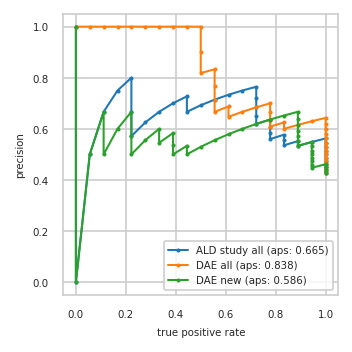

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.533 0.889     0.600 1.000     0.533 0.889
13         0.552 0.889     0.621 1.000     0.552 0.889
14         0.536 0.833     0.643 1.000     0.571 0.889
15         0.556 0.833     0.630 0.944     0.593 0.889
16         0.577 0.833     0.615 0.889     0.615 0.889
17         0.560 0.778     0.600 0.833     0.640 0.889
18         0.583 0.778     0.625 0.833     0.667 0.889
19         0.609 0.778     0.609 0.778     0.652 0.833
20         0.636 0.778     0.636 0.778     0.636 0.778
21         0.619 0.722     0.667 0.778     0.619 0.722
22         0.650 0.722     0.700 0.778     0.600 0.667
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.722 0.722     0.667 0.667     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.733 0.611     0.667 0.556     0.533 0.444
28         0.714 0.556     0.714 0.556     0.500 0.389
29         0.692 0.500     0.769 0.556     0.538 0.389
30         0.667 0.444     0.833 0.556     0.583 0.389
31         0.727 0.444     0.818 0.500     0.545 0.333
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.667 0.333     1.000 0.500     0.556 0.278
34         0.625 0.278     1.000 0.444     0.500 0.222
35         0.571 0.222     1.000 0.389     0.571 0.222
36         0.667 0.222     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


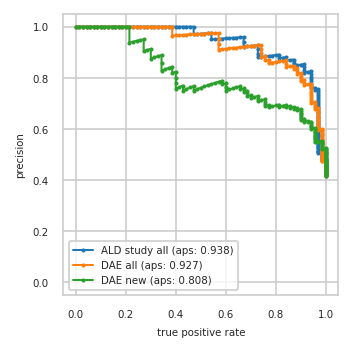

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


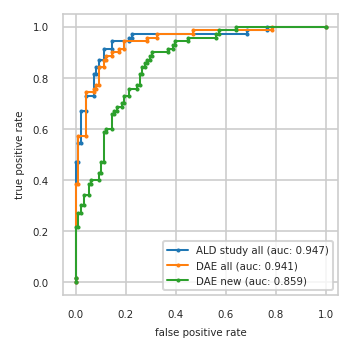

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}